In [235]:
import cdms2 as cdms
import MV2 as MV
import cdtime,cdutil,genutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import string
import glob
import scipy.stats as stats
# Local solution
# If running remotely, uncomment the following code:
# %%bash
# git clone https://github.com/katemarvel/CMIP5_tools
# import CMIP5_tools as cmip5
import sys,os
sys.path.append("../python-utils")

import CMIP5_tools as cmip5
import DA_tools
import Plotting
import cartopy_plot

# cartopy stuff
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry.polygon import LinearRing
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.io.shapereader as shpreader
from cartopy.util import add_cyclic_point

from eofs.cdms import Eof
from eofs.multivariate.cdms import MultivariateEof
%matplotlib inline
import matplotlib.mlab as mlab
import pandas as pd
import requests
rootdirec="/home/kdm2144/"
mary=pd.read_csv("/home/kdm2144/mary_cmip6.csv")


In [2]:
def get_rawdir(variable):
    if variable in os.listdir("/home/kdm2144/DROUGHT/DOWNLOADED_RAW/"):
        rawdir="/home/kdm2144/DROUGHT/DOWNLOADED_RAW/"+variable+"/"
    elif variable in os.listdir("/home/kdm2144/DROUGHT/PROCESSED/"):
        rawdir="/home/kdm2144/DROUGHT/PROCESSED/"+variable+"/"
    else:
        raise TypeError("No directory found for",variable)
    return rawdir

In [3]:
def meshplot_region(mme_diff,extent_lonlat=None,central_longitude=None,central_latitude=None,\
                    cmap_name=plt.cm.BrBG,vmax=None,vmin=None):
    lono=mme_diff.getLongitude()[:]
    lato=mme_diff.getLatitude()[:]
    if central_latitude is None:
        central_latitude=np.median(lato)
    if central_longitude is None:
        central_longitude=np.median(lono)
    lon,lat=np.meshgrid(lono,lato)
    states_provinces = cfeature.NaturalEarthFeature(category='cultural',\
            name='admin_1_states_provinces_lines',\
            scale='50m',\
            facecolor='none')
    
    #clevs = np.array([-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,.3,.4,.5,.6])*2.5
    p5=np.percentile(mme_diff.compressed(),5)
    p95=np.percentile(mme_diff.compressed(),95)
    if vmin is None:
        vmin=-1*max(np.abs(p5),np.abs(p95))
    if vmax is None:
        vmax=max(np.abs(p5),np.abs(p95))
    clevs=np.linspace(vmin,vmax,13)
    clevs_units=clevs.copy()
    nmap = plt.cm.get_cmap(name=cmap_name,lut=clevs.size-1)

    ocean_color = np.float64([209,230,241])/255

    fig = plt.figure(figsize=(12, 12),facecolor="white")
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=central_longitude, central_latitude=central_latitude, globe=None))
    
    m = ax.contourf(lon, lat, mme_diff,clevs,transform=ccrs.PlateCarree(),cmap=nmap,extend="both")
    #m = ax.pcolormesh(lon, lat, mme_diff,vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree(),cmap=nmap)
    ax.coastlines()
    ax.set_global()
    if extent_lonlat is not None:
        ax.set_extent(extent_lonlat, crs=ccrs.PlateCarree())
    #ax.gridlines(xlocs=np.arange(-180,190,10),ylocs=np.arange(-180,190,10))
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='-', edgecolor='k')
    ax.add_feature(states_provinces, linewidth=0.5, linestyle='-', edgecolor='k')
    #ax.add_feature(newcoast, linewidth=0.5, linestyle='-', edgecolor='k')
    #ax.add_feature(newlake, linewidth=0.5, linestyle='-', edgecolor='k')
    ax.add_feature(cartopy.feature.LAND,color='white',zorder=0,edgecolor='k',hatch="/")
    ax.add_feature(cartopy.feature.OCEAN,color=ocean_color,zorder=0,edgecolor='k')
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='-', edgecolor='k')
    ax.add_feature(cartopy.feature.OCEAN,color=ocean_color,zorder=1)
    
    #ax.add_feature(newcoast, linewidth=1, linestyle='-', zorder=2,edgecolor='k')
    #ax.text(-122,21,var_txt+' ('+seas_txt+')',transform=ccrs.PlateCarree(),fontsize=32,fontweight="bold", \
     #horizontalalignment='center', verticalalignment='center',)
    #ax.text(-122,17,ssp_txt,transform=ccrs.PlateCarree(),fontsize=28,fontweight="normal", \
     #horizontalalignment='center', verticalalignment='center',)
    #cbar=plt.colorbar(m,orientation="horizontal",fraction=0.08,pad=0.04)#,ticks=clevs_units[np.arange(0,clevs_units.size+1,2)])
    if ((vmin ==0 ) and (vmax==365)):
        cbar=plt.colorbar(m,orientation="horizontal",fraction=0.08,pad=0.04,ticks=np.linspace(0,365,12))
        cbar.ax.set_xticklabels(["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"])
    else:
        cbar=plt.colorbar(m,orientation="horizontal",fraction=0.08,pad=0.04)
    cbar.ax.tick_params(labelsize=24)
    
    shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
    reader = shpreader.Reader(shpfilename)
    countries = reader.records()
#     if only_India:
#         for country in countries:
#             if country.attributes["NAME"] != "India":
#                 ax.add_geometries(country.geometry, ccrs.PlateCarree(),
#                                   facecolor="w",)

        #ax.add_feature(cartopy.feature.RIVERS,color=ocean_color,zorder=2)



In [243]:
def contourplot_globe(mme_diff,\
                    cmap_name=plt.cm.BrBG,vmax=None,vmin=None,\
                     fig=None, nrows=1,ncols=1,nax=1):
    lon=mme_diff.getLongitude()[:]
    lat=mme_diff.getLatitude()[:]
    
    #lon,lat=np.meshgrid(lono,lato)
    states_provinces = cfeature.NaturalEarthFeature(category='cultural',\
            name='admin_1_states_provinces_lines',\
            scale='50m',\
            facecolor='none')
    
    #clevs = np.array([-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,.3,.4,.5,.6])*2.5
    p5=np.percentile(mme_diff.compressed(),5)
    p95=np.percentile(mme_diff.compressed(),95)
    if vmin is None:
        vmin=-1*max(np.abs(p5),np.abs(p95))
    if vmax is None:
        vmax=max(np.abs(p5),np.abs(p95))
    clevs=np.linspace(vmin,vmax,13)
    clevs_units=clevs.copy()
    nmap = plt.cm.get_cmap(name=cmap_name,lut=clevs.size-1)

    ocean_color = np.float64([209,230,241])/255
    if fig is None:
        fig = plt.figure(figsize=(12, 12),facecolor="white")
    ax = fig.add_subplot(nrows,ncols, nax, projection=ccrs.Robinson())
    
    # Add CYCLIC POINT to avoid white line down meridian
    mme_diff, lon = add_cyclic_point(data, coord=lon)
    
    m = ax.contourf(lon, lat, mme_diff,clevs,transform=ccrs.PlateCarree(),cmap=nmap,extend="both")
    #m = ax.pcolormesh(lon, lat, mme_diff,vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree(),cmap=nmap)
    ax.coastlines()
    ax.set_global()
    
    #ax.gridlines(xlocs=np.arange(-180,190,10),ylocs=np.arange(-180,190,10))
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='-', edgecolor='k')
    ax.add_feature(states_provinces, linewidth=0.5, linestyle='-', edgecolor='k')
    #ax.add_feature(newcoast, linewidth=0.5, linestyle='-', edgecolor='k')
    #ax.add_feature(newlake, linewidth=0.5, linestyle='-', edgecolor='k')
    ax.add_feature(cartopy.feature.LAND,color='white',zorder=0,edgecolor='k',hatch="/")
    ax.add_feature(cartopy.feature.OCEAN,color=ocean_color,zorder=0,edgecolor='k')
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='-', edgecolor='k')
    ax.add_feature(cartopy.feature.OCEAN,color=ocean_color,zorder=1)
    
    #ax.add_feature(newcoast, linewidth=1, linestyle='-', zorder=2,edgecolor='k')
    #ax.text(-122,21,var_txt+' ('+seas_txt+')',transform=ccrs.PlateCarree(),fontsize=32,fontweight="bold", \
     #horizontalalignment='center', verticalalignment='center',)
    #ax.text(-122,17,ssp_txt,transform=ccrs.PlateCarree(),fontsize=28,fontweight="normal", \
     #horizontalalignment='center', verticalalignment='center',)
    #cbar=plt.colorbar(m,orientation="horizontal",fraction=0.08,pad=0.04)#,ticks=clevs_units[np.arange(0,clevs_units.size+1,2)])
    if ((vmin ==0 ) and (vmax==365)):
        cbar=plt.colorbar(m,orientation="horizontal",fraction=0.08,pad=0.04,ticks=np.linspace(0,365,12))
        cbar.ax.set_xticklabels(["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"])
    else:
        cbar=plt.colorbar(m,orientation="horizontal",fraction=0.08,pad=0.04)
    cbar.ax.tick_params(labelsize=24)
    
    shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
    reader = shpreader.Reader(shpfilename)
    countries = reader.records()
#     if only_India:
#         for country in countries:
#             if country.attributes["NAME"] != "India":
#                 ax.add_geometries(country.geometry, ccrs.PlateCarree(),
#                                   facecolor="w",)

        #ax.add_feature(cartopy.feature.RIVERS,color=ocean_color,zorder=2)




In [248]:
def meshplot_globe(mme_diff,\
                    cmap_name=plt.cm.BrBG,vmax=None,vmin=None):
    lono=mme_diff.getLongitude()[:]
    lato=mme_diff.getLatitude()[:]
    
    lon,lat=np.meshgrid(lono,lato)
    states_provinces = cfeature.NaturalEarthFeature(category='cultural',\
            name='admin_1_states_provinces_lines',\
            scale='50m',\
            facecolor='none')
    
    #clevs = np.array([-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,.3,.4,.5,.6])*2.5
    p5=np.percentile(mme_diff.compressed(),5)
    p95=np.percentile(mme_diff.compressed(),95)
    if vmin is None:
        vmin=-1*max(np.abs(p5),np.abs(p95))
    if vmax is None:
        vmax=max(np.abs(p5),np.abs(p95))
    clevs=np.linspace(vmin,vmax,13)
    clevs_units=clevs.copy()
    nmap = plt.cm.get_cmap(name=cmap_name,lut=clevs.size-1)

    ocean_color = np.float64([209,230,241])/255

    fig = plt.figure(figsize=(12, 12),facecolor="white")
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
    #m = ax.contourf(lon, lat, mme_diff,clevs,transform=ccrs.PlateCarree(),cmap=nmap,extend="both")
    
    m = ax.pcolormesh(lon, lat, mme_diff,vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree(),cmap=nmap)
    ax.coastlines()
    ax.set_global()
    
    #ax.gridlines(xlocs=np.arange(-180,190,10),ylocs=np.arange(-180,190,10))
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='-', edgecolor='k')
    ax.add_feature(states_provinces, linewidth=0.5, linestyle='-', edgecolor='k')
    #ax.add_feature(newcoast, linewidth=0.5, linestyle='-', edgecolor='k')
    #ax.add_feature(newlake, linewidth=0.5, linestyle='-', edgecolor='k')
    ax.add_feature(cartopy.feature.LAND,color='white',zorder=0,edgecolor='k',hatch="/")
    ax.add_feature(cartopy.feature.OCEAN,color=ocean_color,zorder=0,edgecolor='k')
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='-', edgecolor='k')
    ax.add_feature(cartopy.feature.OCEAN,color=ocean_color,zorder=1)
    
    #ax.add_feature(newcoast, linewidth=1, linestyle='-', zorder=2,edgecolor='k')
    #ax.text(-122,21,var_txt+' ('+seas_txt+')',transform=ccrs.PlateCarree(),fontsize=32,fontweight="bold", \
     #horizontalalignment='center', verticalalignment='center',)
    #ax.text(-122,17,ssp_txt,transform=ccrs.PlateCarree(),fontsize=28,fontweight="normal", \
     #horizontalalignment='center', verticalalignment='center',)
    #cbar=plt.colorbar(m,orientation="horizontal",fraction=0.08,pad=0.04)#,ticks=clevs_units[np.arange(0,clevs_units.size+1,2)])
    if ((vmin ==0 ) and (vmax==365)):
        cbar=plt.colorbar(m,orientation="horizontal",fraction=0.08,pad=0.04,ticks=np.linspace(0,365,12))
        cbar.ax.set_xticklabels(["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"])
    else:
        cbar=plt.colorbar(m,orientation="horizontal",fraction=0.08,pad=0.04)
    cbar.ax.tick_params(labelsize=24)
    
    shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
    reader = shpreader.Reader(shpfilename)
    countries = reader.records()
#     if only_India:
#         for country in countries:
#             if country.attributes["NAME"] != "India":
#                 ax.add_geometries(country.geometry, ccrs.PlateCarree(),
#                                   facecolor="w",)

        #ax.add_feature(cartopy.feature.RIVERS,color=ocean_color,zorder=2)





In [6]:
def get_tax(experiment,L=None):
    if experiment.find("hist")==0:
        if L is None:
            L=165
        tax=cdms.createAxis(np.arange(L*12))
        tax.designateTime()
        tax.id="time"
        tax.units="months since 1850-1-1"
    elif experiment.find("ssp")==0:
        if L is None:
            L=86
        tax=cdms.createAxis(np.arange(L*12))
        tax.designateTime()
        tax.id="time"
        tax.units="months since 1850-1-1"
    elif experiment.find("piControl")==0:
        if L is None:
            L=500
        tax=cdms.createAxis(np.arange(L*12))
        tax.designateTime()
        tax.id="time"
        tax.units="months since 0001-1-1"
    cdutil.setAxisTimeBoundsMonthly(tax)
    return tax

In [7]:
def get_tax_from_files(fnames):

    minyear=int(fnames[0].split(".")[-2])
    maxyear=int(fnames[-1].split(".")[-2])
    L=maxyear-minyear+1
    tax=cdms.createAxis(np.arange(L*12))
    tax.designateTime()
    tax.id="time"
    tax.units="months since "+str(minyear)+"-1-1"
    cdutil.setAxisTimeBoundsMonthly(tax)
    return tax

In [8]:
def get_firstmember(model,variable,experiment,rip=None):
    rawdir=get_rawdir(variable)
    

    rips=np.unique([x.split(".")[-3] for x in glob.glob(rawdir+model+"/*"+experiment+"*")])
    if rip is None:
        rip=rips[0]
    fnames=sorted(get_filenames(model,variable,experiment,rip))
    L=len(fnames)
    #get shape
    f=cdms.open(glob.glob(rawdir+model+"/"+variable+"."+experiment+"."+model+"."+rips[0]+".*")[0])

    gridsize=(f[variable].shape)[1:]

    f.close()
    
    nyears=L*12
    simulationdata=MV.zeros((nyears,)+gridsize)


    fnames=sorted(glob.glob(rawdir+model+"/"+variable+"."+experiment+"."+model+"."+rip+".*"))
    for timei in range(len(fnames)):
        f=cdms.open(fnames[timei])
        data=f(variable)
        simulationdata[12*timei:12*(timei+1)]=data
        f.close()



    tax=get_tax_from_files(fnames)
    latax=data.getLatitude()
    lonax=data.getLongitude()
    axlist=[tax,latax,lonax]
    simulationdata.setAxisList(axlist)
    simulationdata.id=variable
    cdutil.setTimeBoundsMonthly(simulationdata)
    return simulationdata

In [47]:

def get_ensemble(model,variable,experiment):
    rawdir=get_rawdir(variable)
   
    
    rips=np.unique([x.split(".")[-3] for x in glob.glob(rawdir+model+"/*"+experiment+"*")])
    nrips=len(rips)
    fnames=sorted(get_filenames(model,variable,experiment,rips[0]))
    L=len(fnames)
    
    #get shape
    f=cdms.open(glob.glob(rawdir+model+"/"+variable+"."+experiment+"."+model+"."+rips[0]+".*")[0])

    gridsize=(f[variable].shape)[1:]

    f.close()
    historical=MV.zeros((nrips,L*12)+gridsize)

    for ripi in range(len(rips)):
        rip=rips[ripi]
        fnames=sorted(glob.glob(rawdir+model+"/"+variable+"."+experiment+"."+model+"."+rip+".*"))
        for timei in range(len(fnames)):
            f=cdms.open(fnames[timei])
            data=f(variable)
            historical[ripi,12*timei:12*(timei+1)]=data
            f.close()


    fnames_rip=[variable+"."+experiment+"."+model+"."+rip for rip in rips]
    modax=cmip5.make_model_axis(fnames_rip)
    tax=get_tax_from_files(fnames)
    latax=data.getLatitude()
    lonax=data.getLongitude()
    axlist=[modax,tax,latax,lonax]
    historical.setAxisList(axlist)
    historical.id=variable
    cdutil.setTimeBoundsMonthly(historical)
    return historical

In [10]:
def multi_model_ensemble(variable,experiment,model_ensemble_average=False,models=None,grid=None):
    rawdir=get_rawdir(variable)
    if experiment.find("hist")>=0:
        time_bounds=('1850-1-1','2014-12-31')
    elif experiment.find("ssp")>=0:
        time_bounds=('2015-1-1','2100-12-31')
        
    tax=get_tax(experiment)
    L=int(len(tax)/12)
    
    if models is None:
        models=cmip6_models_with_all_variables([variable],experiment)
    if grid is None:
        model = models[0]
        
        rip=get_rips(model,variable,experiment)[0]
        allfiles=sorted(glob.glob(rawdir+model+"/*."+experiment+".*."+rip+".*"))

        f=cdms.open(allfiles[0])
        data=f(variable)
        #for model in get_ok_models("SW"):

        grid=data.getGrid()
        
        f.close()
    nmod=len(models)
    MME=MV.zeros((nmod,L*12)+grid.shape)+1.e20
    for i in range(nmod):
        print(models[i])
        model=models[i]
        if model_ensemble_average:
            ens=get_ensemble(model,variable,experiment)
            
            data=MV.average(ens,axis=0)
        else:
            data=get_firstmember(model,variable,experiment)
        
        data_regrid=data.regrid(grid,regridTool='regrid2')(time=time_bounds)
        if data_regrid.shape == MME[i].shape:
            MME[i]=data_regrid
        else:
            print("problem with",model)
    MME=MV.masked_where(MME>1.e10,MME)
    modax=cmip5.make_model_axis(models)
    lat=grid.getLatitude()
    lon=grid.getLongitude()
    axlist=[modax,tax,lat,lon]
    MME.setAxisList(axlist)  
    MME.id=variable
    return MME

In [12]:
def concatenated_piControl(models,variable,L=500,grid=None):

    rawdir=get_rawdir(variable)
    if grid is None:
        model = "CESM2"

        rip="r1i1p1f1"
        allfiles=sorted(glob.glob(rawdir+variable+"/"+model+"/*.historical.*."+rip+".*"))

        f=cdms.open(allfiles[0])
        data=f(variable)
        #for model in get_ok_models("SW"):

        grid=data.getGrid()
        f.close()
    
    nmod=len(models)
    
    allpiC=MV.zeros((nmod,L*12)+grid.shape)
    for i in range(nmod):
        print(models[i])
        data=get_piControl_firstmember(models[i],variable,L=L)
        data_regrid=data.regrid(grid,regridTool='regrid2')
        allpiC[i]=data_regrid

    modax=cmip5.make_model_axis(models)
    allpiC.setAxisList([modax]+data_regrid.getAxisList())  
    allpiC.id=variable
    return allpiC


In [13]:
def mask_data(data,basicmask):
    dim = len(data.shape)
    if dim == 2:
        mask= basicmask
    elif dim ==3:
        nt = data.shape[0]
        mask= np.repeat(basicmask[np.newaxis,:,:],nt,axis=0)
    elif dim ==4:
        nmod,nt,nx,ny = data.shape
        mask= np.repeat(np.repeat(basicmask[np.newaxis,:,:],nt,axis=0)[np.newaxis],nmod,axis=0)
    return MV.masked_where(mask,data)

In [14]:
def get_land_frac(model):
    fixedvardirec="/home/kdm2144/DROUGHT/fixedvar/"
    landfiles=glob.glob(fixedvardirec+"sftlf*"+model+".*")
    if len(landfiles)==1:
        fland=cdms.open(landfiles[0])
        landfrac=fland("sftlf")
        fland.close()
        return landfrac
    else:
        print("can't find land fraction file for", model)
        return 0

In [15]:
def mask_land(data,model,land_percent_thresh=100.):
    lf=get_land_frac(model)
    landmask=lf.asma() < land_percent_thresh
    return mask_data(data,landmask)

In [16]:
def get_filenames(model,variable,experiment,rip):
    rawdir=get_rawdir(variable)
    return sorted(glob.glob(rawdir+model+"/*."+experiment+".*"+rip+".*"))

In [17]:
def get_rips(model,variable,experiment):
    rawdir=get_rawdir(variable)
    rips=np.unique([x.split(".")[-3] for x in glob.glob(rawdir+model+"/*"+experiment+"*")])
    return rips

In [18]:
def model_dataframes(variable):
    d={}
    direc="/home/kdm2144/DROUGHT/DOWNLOADED_RAW/"+variable+"/"
    models=sorted(os.listdir(direc))

    for model in models:
        d[model]={}
        experiments=np.unique([x.split(".")[1] for x in os.listdir(direc+model+"/")])
        for experiment in experiments:
            rips=np.unique([x.split(".")[3] for x in glob.glob(direc+model+"/*."+experiment+".*")])
            numrips=len(rips)
            d[model][experiment]+=[numrips]
    #df=pd.DataFrame(data=d)
    #df.index =experiments
    return d


In [19]:
def get_dataframe_downloaded():
    df = pd.DataFrame(columns=["filename","variable","model","experiment","rip"])
    fnames=[]
    models=[]
    experiments=[]
    rips=[]
    variables=[]
    for root, dir, files in os.walk("/home/kdm2144/DROUGHT/PROCESSED/"):
        for f in files:
            variable,experiment,model,rip,year,suffix=f.split(".")
            variables+=[variable]
            models+=[model]
            experiments+=[experiment]
            rips+=[rip]
            fnames+=[f]
        df1 = pd.DataFrame({'filename': fnames,
                            'variable': variables,
                            'model': models,
                            'experiment': experiments,
                            'rip': rips})
        df = df.append(df1)
    return df

In [21]:
def cmip6_models_with_all_variables(variables,experiment):
    models=np.unique(mary[(mary.experiment_id==experiment) & (mary.variable_id==variables[0])].source_id)
    for variable in variables[1:]:
        models2=np.unique(mary[(mary.experiment_id==experiment) & (mary.variable_id==variable)].source_id)
        models=np.intersect1d(models,models2)
    return models

def subset_CMIP6_models(variables,experiments):
    models=cmip6_models_with_all_variables(variables,experiments[0])
    for experiment in experiments:
        models2=cmip6_models_with_all_variables(variables,experiment)
        models=np.intersect1d(models,models2)
    return models

pet_variables=["hfls","hfss","sfcWind","huss","ps","tas"]
experiments=["piControl","historical","ssp126","ssp585","ssp370","ssp245"]

In [108]:
def opendap_data(curr_mod,curr_var,experiment_id,member_id):

    # Baseline directory
    base_dir   = 'http://mary.ldeo.columbia.edu:81/CMIP6/.'
    # Write directory
    
   
    df_proclist = pd.DataFrame(columns=['model','sim','ensemble','variable'])
    #ingrid_cmip6 = pd.read_csv("~/mary_cmip6.csv")



    
    #rips=np.unique(np.array(df1.member_id))

    df1=mary[(mary.source_id == curr_mod)\
                    & (mary.variable_id == curr_var) & \
                    (mary.experiment_id == experiment_id) &\
                    (mary.member_id == member_id)]
    

    #Construct openDAP link
    nfiles,nidentifiers=df1.shape
    times=np.sort(np.array(df1.time_range))
    
    time_range=times[0]

 
    i_ens=np.where(df1.time_range==time_range)[0][0]
    nc_link = base_dir+df1.activity_id.iloc[i_ens]+'/.'+df1.institution_id.iloc[i_ens]+'/.'+curr_mod+'/.'+experiment_id+'/.'+df1.member_id.iloc[i_ens]+'/.'+df1.table_id.iloc[i_ens]+ \
                        '/.'+curr_var+'/.'+df1.grid_label.iloc[i_ens]+'/.'+df1.version.iloc[i_ens]+'/.'+df1.file_basename.iloc[i_ens]+'/.'+curr_var+'/dods'
    request = requests.get(nc_link)
   
    if request.status_code != 200:
        raise TypeError("Can't open file: bad request for time range", time_range)
     
    f=cdms.open(nc_link)
    data=f(variable)
    f.close()
    if len(times)>1:
        for time_range in times[1:]:
            i_ens=np.where(df1.time_range==time_range)[0][0]
            nc_link = base_dir+df1.activity_id.iloc[i_ens]+'/.'+df1.institution_id.iloc[i_ens]+'/.'+curr_mod+'/.'+experiment_id+'/.'+df1.member_id.iloc[i_ens]+'/.'+df1.table_id.iloc[i_ens]+ \
                                '/.'+curr_var+'/.'+df1.grid_label.iloc[i_ens]+'/.'+df1.version.iloc[i_ens]+'/.'+df1.file_basename.iloc[i_ens]+'/.'+curr_var+'/dods'
            request = requests.get(nc_link)
            if request.status_code != 200:
                raise TypeError("Can't open file: bad request for time range", time_range)
                #return 0
            f=cdms.open(nc_link)
            datat=f(variable)
            f.close()
            data=MV.concatenate((data,datat))

        atts=datat.attributes.keys()
        for att in atts:
            setattr(data,att,datat.attributes[att])
        data.id=datat.id
    return data




In [71]:
def check_availability_opendap(curr_mod,curr_var,experiment_id):
    #Mary = pd.read_csv("~/mary_cmip6.csv")
    df1 = mary[(mary.source_id==curr_mod)\
                       & (mary.variable_id==curr_var)\
                       & (mary.experiment_id == experiment_id)]
    return(df1)
def get_rips_opendap(curr_mod,curr_var,experiment_id):
    df1=check_availability(curr_mod,curr_var,experiment_id)
    return(np.unique(df1.member_id))

In [111]:
def opendap_ensemble(model,variable,experiment):
    rips=get_rips_opendap(model,variable,experiment)
    L=len(rips)
    
    i=0
    ens_member=opendap_data(model,variable,experiment,rips[i])
    ENS=MV.zeros((L,)+ens_member.shape)+1.e20
    ENS[i]=ens_member
    if L>1:
        for i in range(L)[1:]:
            try:
                ens_member=opendap_data(model,variable,experiment,rips[i])
                ENS[i]=ens_member
            except:
                print("problem downloading ",rips[i])
     
    ENS=MV.masked_where(ENS>1.e10,ENS)
    fnames_rip=[variable+"."+experiment+"."+model+"."+rip for rip in rips]
    modax=cmip5.make_model_axis(fnames_rip)
    axlist=[modax]+ens_member.getAxisList()
    ENS.id=variable
    ENS.setAxisList(axlist)
    cdutil.setTimeBoundsMonthly(ENS)
    return ENS

In [30]:
allmodels=os.listdir(get_rawdir("mrsos"))
ok=[]
for model in allmodels:
    if len(glob.glob("/home/kdm2144/DROUGHT/DOWNLOADED_RAW/mrsos/"+model+"/*.hist-aer.*")) >0:
        ok+=[model]

In [31]:
sorted(ok)

['ACCESS-ESM1-5',
 'BCC-CSM2-MR',
 'CESM2',
 'CanESM5',
 'GISS-E2-1-G',
 'MIROC6',
 'MRI-ESM2-0',
 'NorESM2-LM']

In [76]:
variable="mrsos"
model="MIROC6"
experiment="hist-aer"

#ens_member=opendap_data(model,variable,experiment,rip)
MIROC_test=opendap_ensemble(model,variable,experiment)

In [112]:
CanESM5_test=opendap_ensemble("CanESM5",variable,experiment)

problem downloading  r1i1p1f1
problem downloading  r3i1p1f1
problem downloading  r4i1p1f1
problem downloading  r6i1p1f1
problem downloading  r7i1p1f1


In [118]:
cdutil.setTimeBoundsMonthly(MIROC_test)
MIROC_av=MV.average(cdutil.JJA(MIROC_test),axis=0)

/home/kdm2144/miniconda3/envs/cdatpy3scipy/lib/python3.6/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/home/kdm2144/miniconda3/envs/cdatpy3scipy/lib/python3.6/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


In [126]:
solver=Eof(MIROC_av(time=('1950-1-1','2014-12-31')))

/home/kdm2144/miniconda3/envs/cdatpy3scipy/lib/python3.6/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


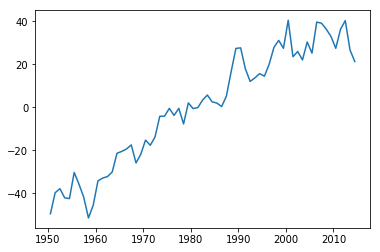

In [129]:
Plotting.time_plot(solver.pcs()[:,0])

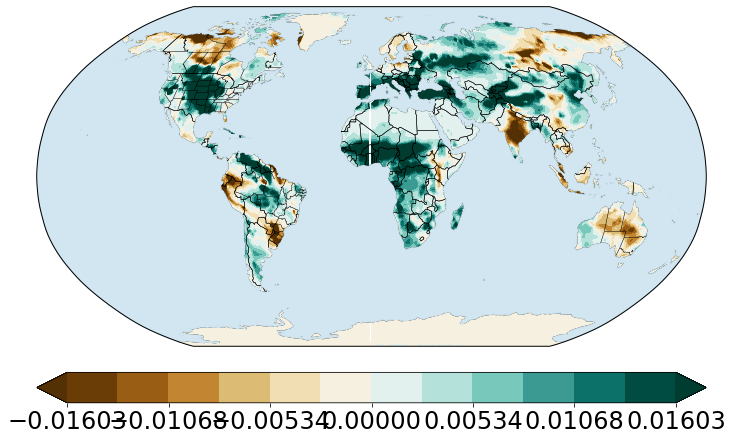

In [130]:
contourplot_globe(solver.eofs()[0])

In [125]:
solver.varianceFraction()[:5]*100

/home/kdm2144/miniconda3/envs/cdatpy3scipy/lib/python3.6/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


variable_3720
masked_array(data=[25.0046279 ,  6.31761692,  4.19350613,  2.71216742,
                    2.14928097],
             mask=False,
       fill_value=1e+20)

In [78]:
models=subset_CMIP6_models([variable],["hist-GHG","hist-aer"])


In [80]:
GFDL_test.shape

(1, 2052, 180, 288)

In [81]:
CESM_test.shape

(2, 1980, 192, 288)

In [195]:
def get_opendap_multimodel_dictionary(variable,experiment,grid=None):

    grid=None
    d={}
    badmodels=[]
    models=cmip6_models_with_all_variables([variable],experiment)
    for model in models:
        try:
            ens=opendap_ensemble(model,variable,experiment)
            d[model]=ens
        except:
            badmodels+=[model]
    return d
        

In [196]:
def dictionary_ensemble_average(d,grid=None):
    if grid is None:
        shape=1.e20
        if grid is None:
            for m in d.keys():
                gridsize=d[m].shape[-1]*d[m].shape[-2]
                if gridsize<shape:
                    shape=gridsize
                    themodel=m
        coarsest_grid=d[themodel].getGrid()
        allstop=str(np.min([cmip5.stop_time(d[m]).year for m in d.keys()]))+"-12-31"
        allstart=str(np.max([cmip5.start_time(d[m]).year for m in d.keys()]))+"-1-11"
        standardize = lambda data: data(time=(allstart,allstop)).regrid(coarsest_grid,regridTool='regrid2')
        counter=0
        goodmodels=list(d)
        L=len(goodmodels)

        for m in d.keys():
            modeldata=standardize(MV.average(d[m],axis=0)) # average over individual ensemble members
            if counter==0:
                MME=MV.zeros((L,)+modeldata.shape)
            MME[counter]=modeldata
            counter+=1




/home/kdm2144/miniconda3/envs/cdatpy3scipy/lib/python3.6/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/home/kdm2144/miniconda3/envs/cdatpy3scipy/lib/python3.6/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


In [200]:
modax=cmip5.make_model_axis(list(d))
axlist=[modax]+modeldata.getAxisList()

MME.setAxisList(axlist)
cdutil.setTimeBoundsMonthly(MME)

In [222]:
lat=MME.getLatitude()[:]
lon=MME.getLongitude()[:]
x,y=np.meshgrid(lon,lat)

DJF=cdutil.DJF.departures(MME)[:,:-1]
JJA=cdutil.JJA.departures(MME)
northern_hemisphere= np.broadcast_to(y>0,DJF.shape)
summerseason=MV.where(northern_hemisphere,JJA,DJF)

In [225]:
summerseason.setAxisList(JJA.getAxisList())

In [226]:
solver=Eof(MV.average(summerseason,axis=0))

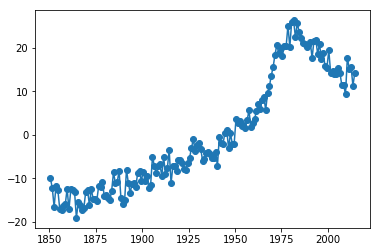

In [234]:
Plotting.time_plot(solver.pcs()[:,0],marker="o")

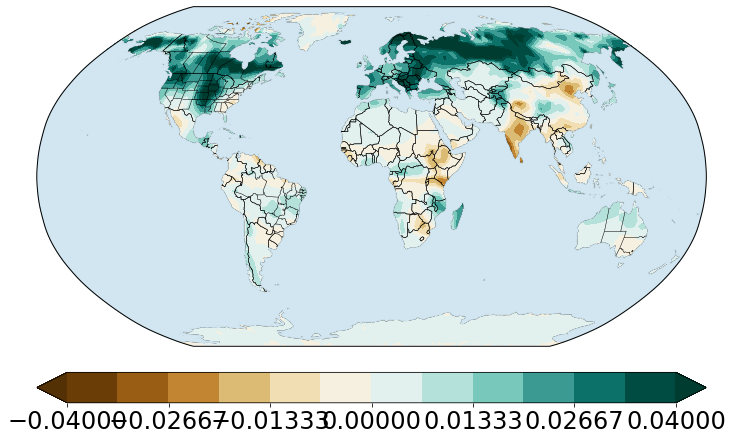

In [253]:
contourplot_globe(solver.eofs()[0],vmin=-.04,vmax=0.04)

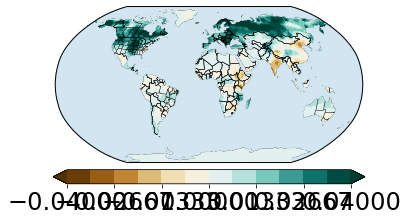

In [257]:
fig=plt.figure(figsize=(30,15))
contourplot_globe(solver.eofs()[0],vmin=-.04,vmax=0.04,nrows=4,ncols=2,nax=1,fig=fig)

/home/kdm2144/miniconda3/envs/cdatpy3scipy/lib/python3.6/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/home/kdm2144/miniconda3/envs/cdatpy3scipy/lib/python3.6/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


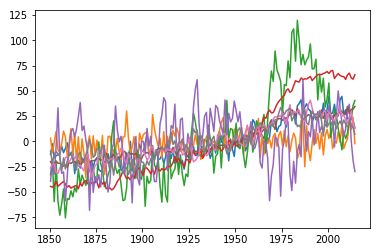

In [260]:
for i in range(summerseason.shape[0]):
    modsolver=Eof(summerseason[i])
    Plotting.time_plot(modsolver.pcs()[:,0])

In [261]:
f=cdms.open("ALL_ANZDA.nc")
trees=f("pdsi")
f.close()

In [263]:
trees_regrid=trees.regrid(coarsest_grid,regridTool='regrid2')

/home/kdm2144/miniconda3/envs/cdatpy3scipy/lib/python3.6/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/home/kdm2144/miniconda3/envs/cdatpy3scipy/lib/python3.6/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


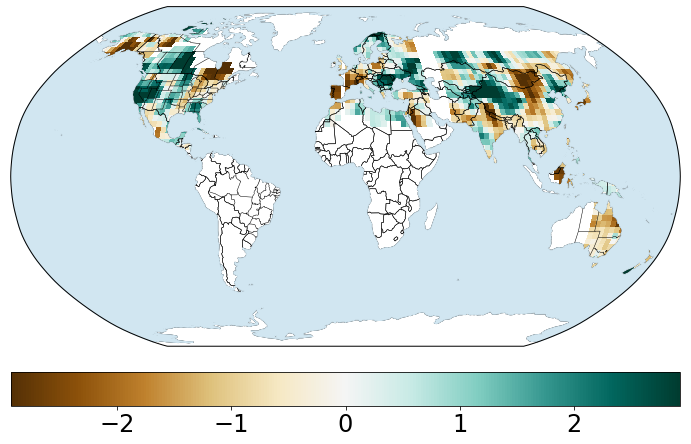

In [266]:
meshplot_globe(trees_regrid[-1])

In [268]:
models_mask=MV.masked_where(np.broadcast_to(trees_regrid[-1].mask,summerseason.shape),summerseason)

solver_mask=Eof(MV.average(models_mask,axis=0))

/home/kdm2144/miniconda3/envs/cdatpy3scipy/lib/python3.6/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/home/kdm2144/miniconda3/envs/cdatpy3scipy/lib/python3.6/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


/home/kdm2144/miniconda3/envs/cdatpy3scipy/lib/python3.6/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


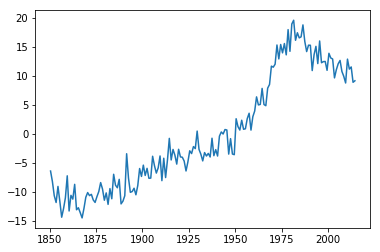

In [272]:
Plotting.time_plot(solver_mask.pcs()[:,0])

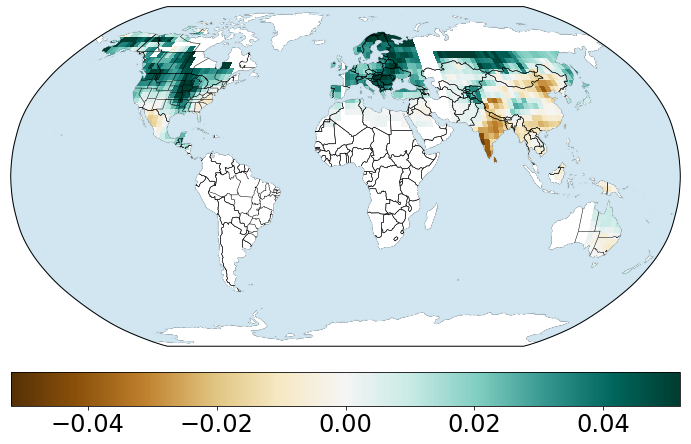

In [275]:
meshplot_globe(solver_mask.eofs()[0])

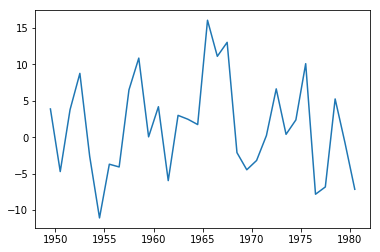

In [286]:
Plotting.time_plot(solver_mask.projectField(trees_regrid)[:,0](time=('1950-1-1','1980-12-31')))

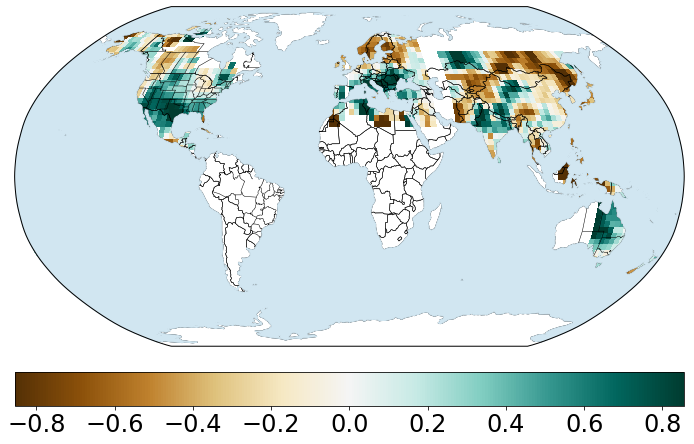

In [283]:
meshplot_globe(cmip5.get_linear_trends(trees_regrid(time=('1950-1-1','1980-12-31'))))

In [287]:
f=cdms.open("NADA_original.nc")
NADA=f("pdsi")
f.close()


/home/kdm2144/miniconda3/envs/cdatpy3scipy/lib/python3.6/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/home/kdm2144/miniconda3/envs/cdatpy3scipy/lib/python3.6/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


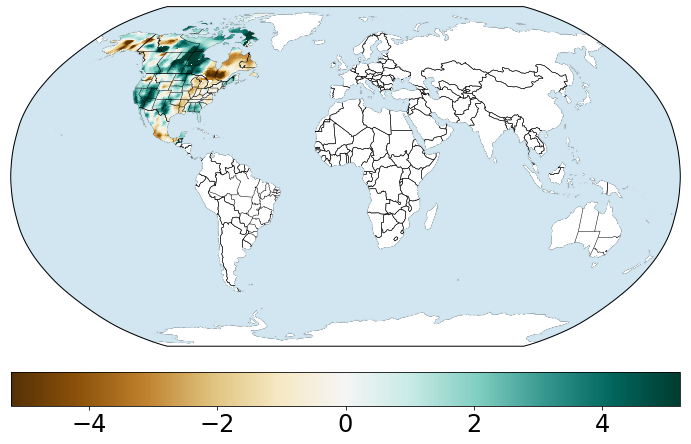

In [289]:
meshplot_globe(NADA[-1])

In [ ]:
summerseason_NADA=summerseason.regrid(NADA.getGrid(),regridTool='regrid2')

In [ ]:
NADA_regrid
models_NADA=MV.masked_where(np.broadcast_to(trees_regrid[-1].mask,summerseason.shape),summerseason)

solver_mask=Eof(MV.average(models_mask,axis=0))